# 기상과 지하철 혼잡도 상관분석 예측
- [공모전 링크](https://bd.kma.go.kr/contest/main.do)
- 데이터 분석과제

## 환경 설정

In [1]:
# 임포트

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

import holidays
from datetime import date

import warnings
warnings.filterwarnings('ignore')

import gc
import pickle

In [2]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 변수 생성

root_path = '/content/drive/MyDrive/AIVLE/공모전/기상청 빅데이터 콘테스트'    # 본인 데이터 경로 작성

In [4]:
# 그래프 크기조정

plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

# 제공 데이터 확인

- `tm`: 시간 / 날짜 및 시각 (지하철 운행시간 동안만 제공)
- `line`: 호선 / 지하철 호선
- `station_number`: 역번호
- `station_name`: 역명
- `direction`: 상하구분 / 지하철 상행 하행 구분
- `stn`: AWS 지점 코드
- `ta`: 기온 / 정시기온 / 섭씨
- `wd`: 풍향 / 정시 10분 평균 풍향 / degree
- `ws`: 풍속 / 정시 10분 평균 풍속 / m/s
- `rn_day`: 일 강수량 / 0 ~ 24시 까지 일 강수량 / mm
- `rn_hr1`: 시간 강수량 / 1시간 강수량 / mm
- `hm`: 상대습도 / 정시 상대 습도 / %
- `si`: 일사량 / ASOS 일사량 / MJ/m^2
- `ta_chi`: 체감온도 / 500m 객관분석 자료 / 섭씨
- `congrestion`: 혼잡도 / 열차 내 혼잡도 / %

## 데이터 병합

In [ ]:
# 데이터 불러오기

train1 = pd.read_csv(root_path + '/train_subway21.csv', index_col=0)
train2 = pd.read_csv(root_path + '/train_subway22.csv', index_col=0)
train3 = pd.read_csv(root_path + '/train_subway23.csv', index_col=0)

# 칼럼 명 변경

train1.columns = train1.columns.str.replace('train_subway21.', '', regex=False)
train2.columns = train2.columns.str.replace('train_subway22.', '', regex=False)
train3.columns = train3.columns.str.replace('train_subway23.', '', regex=False)

# 병합

train = pd.concat([train1, train2, train3], ignore_index=True)

# 날짜 분리

train['tm'] = train['tm'].astype(str)
train.insert(0, 'year', train['tm'].str[:4].astype(int))
train.insert(1, 'month', train['tm'].str[4:6].astype(int))
train.insert(2, 'day', train['tm'].str[6:8].astype(int))
train.insert(3, 'hour', train['tm'].str[8:10].astype(int))

# 데이터 정렬

train = train.sort_values(by=['station_number', 'year', 'month', 'day', 'hour'], ascending=True)

# 데이터 저장

train.to_csv(root_path + '/train_subway.csv', index=False)

# 메모리 해제

del train1, train2, train3, train
gc.collect()

## 병합 데이터 불러오기

In [ ]:
train = pd.read_csv(root_path + '/train_subway.csv')

## 데이터 전처리

기온(ta), 풍향(wd), 풍속(ws), 일 강수량(rn_day), 시간 강수량(rn_hr1), 상대습도(hm), 체감온도(ta_chi) 컬럼 이상치 보간법으로 처리
- -99.0 값인 데이터가 중간중간 존재하므로 전과 이후의 중간 값으로 처리.
- 풍향(wd) 컬럼은 -9.9 값 포함.

In [ ]:
train['ta'] = train['ta'].replace(-99.0, np.nan)

train['wd'] = train['wd'].mask(train['wd'] < 0, np.nan)

train['ws'] = train['ws'].replace(-99.0, np.nan)

train['rn_day'] = train['rn_day'].replace(-99.0, np.nan)

train['rn_hr1'] = train['rn_hr1'].replace(-99.0, np.nan)

train['hm'] = train['hm'].replace(-99.0, np.nan)

train['ta_chi'] = train['ta_chi'].replace(-99.0, np.nan)

일사량(si) 컬럼 이상치 처리
- 일사량이 존재하지 않는 일출 전(5시 전), 일몰 후(21시 후) 전부 값 0 으로 수정
- 각 앞의 시간(6시, 20시) 중 이상치 값(-99.0)을 0 으로 수정
- 이를 제외한 이상치 전부 중간값으로 처리

In [ ]:
train.loc[train['hour'].isin([0, 1, 5, 21, 22, 23]), 'si'] = 0
train.loc[(train['hour'].isin([6, 20])) & (train['si'] == -99.0), 'si'] = 0
train['si'] = train['si'].replace(-99.0, np.nan)

In [ ]:
# 전처리 데이터 저장

train.to_csv(root_path + '/train_subway_pp.csv', index=False)

## 데이터 확인 및 분할

In [6]:
# 전처리 데이터 불러오기

train = pd.read_csv(root_path + '/train_subway_pp.csv')

In [7]:
# null값 중간값으로 처리

def interpolate(train_df):
    interpolate_columns = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'ta_chi']

    for col in interpolate_columns:
        train_df[col] = train_df[col].interpolate()

    train_df['rn_day'] = train_df.groupby(['day'])['rn_day'].transform(lambda x: x.interpolate())

    return train_df

In [8]:
# 기상특보 발표기준에 따른 칼럼 추가

def weather_report(train_df):
    # 한파
    train_df['ta_chi_cold_caution'] = (train_df['ta_chi'] <= -12) & (train_df['ta_chi'] > -15)
    train_df['ta_chi_cold_alert'] = train_df['ta_chi'] <= -15

    # 폭염
    train_df['ta_chi_hot_caution'] = (train_df['ta_chi'] >= 33) & (train_df['ta_chi'] < 35)
    train_df['ta_chi_hot_alert'] = train_df['ta_chi'] >= 35

    # 풍속
    train_df['ws_caution'] = (train_df['ws'] >= 14) & (train_df['ws'] < 21)
    train_df['ws_alert'] = (train_df['ws'] >= 21)

    # 호우
    train_df['rn_hr3_caution'] = (train_df['rn_hr1']) >= 20
    train_df['rn_hr3_alert'] = (train_df['rn_hr1']) >= 30

    # 비오는 날, 현재 비오는 시간 체크
    train_df['rainy_day'] = train_df['rn_day'] > 0
    train_df['raining'] = train_df['rn_hr1'] > 0

    return train_df

In [9]:
# 휴일 컬럼 추가

def off_day(train_df):
    kr_holidays = holidays.KR()

    def check_holidays(row):
        d = date(row['year'], row['month'], row['day'])
        return d in kr_holidays

    def check_weekend(row):
        d = date(row['year'], row['month'], row['day'])
        return d.weekday() >= 5

    train_df['is_holiday'] = train_df.apply(check_holidays, axis=1)
    train_df['is_weekend'] = train_df.apply(check_weekend, axis=1)

    return train_df

In [10]:
# 지하철 방향 더미화

def direction(train_df):
    train_df['direction'] = pd.Categorical(train_df['direction'], categories=['내선', '외선', '상선', '하선'])
    train_dummies = pd.get_dummies(train_df[['direction']])

    train_df = pd.concat([train_df, train_dummies], axis=1)
    return train_df

In [11]:
# 코로나 거리두기 단계 위험도 가중치

def corona(train_df):
    train_df['corona_level'] = 0  # 기본값 설정

    train_df.loc[(train_df['tm'] >= 2020120800) & (train_df['tm'] < 2021021500), 'corona_level'] = 5
    train_df.loc[(train_df['tm'] >= 2021021500) & (train_df['tm'] < 2021071200), 'corona_level'] = 4
    train_df.loc[(train_df['tm'] >= 2021071200) & (train_df['tm'] < 2021110100), 'corona_level'] = 5
    train_df.loc[(train_df['tm'] >= 2021110100) & (train_df['tm'] < 2021121800), 'corona_level'] = 2
    train_df.loc[(train_df['tm'] >= 2021121800) & (train_df['tm'] < 2022041800), 'corona_level'] = 4
    train_df.loc[(train_df['tm'] >= 2022041800) & (train_df['tm'] < 2023032100), 'corona_level'] = 1    # 실내 마스크 의무 해제

    return train_df

In [12]:
# 데이터 분할 저장

for idx, station_number in enumerate(list(train['station_number'].unique())):
    print(idx + 1, '/', len(train['station_number'].unique()), ':', station_number)
    split_train = train.loc[train['station_number']==station_number]

    split_train = interpolate(split_train)
    split_train = weather_report(split_train)
    split_train = off_day(split_train)
    split_train = direction(split_train)
    split_train = corona(split_train)

    split_train.to_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv', index=False)

1 / 374 : 150
2 / 374 : 151
3 / 374 : 152
4 / 374 : 153
5 / 374 : 154
6 / 374 : 155
7 / 374 : 156
8 / 374 : 157
9 / 374 : 158
10 / 374 : 159
11 / 374 : 201
12 / 374 : 202
13 / 374 : 203
14 / 374 : 204
15 / 374 : 205
16 / 374 : 206
17 / 374 : 207
18 / 374 : 208
19 / 374 : 209
20 / 374 : 210
21 / 374 : 211
22 / 374 : 212
23 / 374 : 213
24 / 374 : 214
25 / 374 : 215
26 / 374 : 216
27 / 374 : 217
28 / 374 : 218
29 / 374 : 219
30 / 374 : 220
31 / 374 : 221
32 / 374 : 222
33 / 374 : 223
34 / 374 : 224
35 / 374 : 225
36 / 374 : 226
37 / 374 : 227
38 / 374 : 228
39 / 374 : 229
40 / 374 : 230
41 / 374 : 231
42 / 374 : 232
43 / 374 : 233
44 / 374 : 234
45 / 374 : 235
46 / 374 : 236
47 / 374 : 237
48 / 374 : 238
49 / 374 : 239
50 / 374 : 240
51 / 374 : 241
52 / 374 : 242
53 / 374 : 243
54 / 374 : 309
55 / 374 : 310
56 / 374 : 311
57 / 374 : 312
58 / 374 : 313
59 / 374 : 314
60 / 374 : 315
61 / 374 : 316
62 / 374 : 317
63 / 374 : 318
64 / 374 : 319
65 / 374 : 320
66 / 374 : 321
67 / 374 : 322
68 /

# 데이터 분석

In [13]:
station_numbers = ['150', '151', '152', '153', '154', '155', '156', '157', '158', '159',

                   '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219',
                   '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243',

                   '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329',
                   '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342',

                   '405', '406', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419',
                   '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434',

                   '1002', '1003', '1004', '1005', '1006', '1007', '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1032',

                   '1450', '1451', '1452', '1453', '1454', '1455', '1456', '1457', '1458',

                   '1701', '1751', '1752', '1753', '1754', '1755', '1756', '1757', '1758', '1759', '1760', '1761', '1762', '1763',

                   '1801', '1802', '1803', '1804', '1805', '1806', '1807', '1808', '1809', '1810', '1811', '1812', '1813', '1814', '1815', '1816', '1817', '1821', '1822', '1823',

                   '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919',
                   '1948', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958',

                   '2511', '2512', '2513', '2514', '2515', '2516', '2517', '2518', '2519',
                   '2520', '2521', '2522', '2523', '2524', '2525', '2526', '2527', '2528', '2529',
                   '2530', '2531', '2532', '2533', '2534', '2535', '2536', '2537', '2538', '2539',
                   '2540', '2541', '2542', '2543', '2544', '2545', '2546', '2547', '2548', '2549',
                   '2550', '2551', '2552', '2553', '2554',
                   '2562', '2563', '2564', '2565', '2566',

                   '2611', '2612', '2613', '2614', '2615', '2616', '2617', '2618', '2619',
                   '2620', '2621', '2622', '2623', '2624', '2625', '2626', '2627', '2628', '2629',
                   '2630', '2631', '2632', '2633', '2634', '2635', '2636', '2637', '2638', '2639',
                   '2640', '2641', '2642', '2643', '2644', '2645', '2646', '2647', '2648', '2649',

                   '2711', '2712', '2713', '2714', '2715', '2716', '2717', '2718', '2719',
                   '2720', '2721', '2722', '2723', '2724', '2725', '2726', '2727', '2728', '2729',
                   '2730', '2731', '2732', '2733', '2734', '2735', '2736', '2737', '2738', '2739',
                   '2740', '2741', '2742', '2743', '2744', '2745', '2746', '2747', '2748', '2749',
                   '2750', '2751', '2752', '2753', '2754', '2755', '2756', '2757', '2758', '2759',
                   '2760', '2761',

                   '2811', '2812', '2813', '2814', '2815', '2816', '2817', '2818', '2819',
                   '2820', '2821', '2822', '2823', '2824', '2825', '2826', '2827', '2828',

                   '3753', '3754', '3755', '3756', '3757', '3758', '3759', '3760', '3761', '3762', '3763',

                   '9001', '9006']
                   # 1949 제외

### 머신러닝 분석 결과

#### > 결과 확인 후 추가 데이터 전처리
- 1949(지축) 혼잡도 데이터는 309(지축)과 중복되는 오류 데이터로 제거


#### 분석 코드

In [17]:
def random_forest_test(train_df):
    # 데이터 쪼개기 + 스케일링
    use_columns = (['hour'] +
                   ['ta_chi', 'ta_chi_cold_caution', 'ta_chi_cold_alert', 'ta_chi_hot_caution', 'ta_chi_hot_alert'] +
                   ['ws_caution', 'ws_alert', 'rn_hr3_caution', 'rn_hr3_alert'] +
                   ['rainy_day', 'raining'] +
                   ['is_holiday', 'is_weekend'] +
                   ['corona_level'] +
                   ['direction_내선', 'direction_외선', 'direction_상선', 'direction_하선'])
    target_column = ['congestion']

    X = train_df[use_columns]
    y = train_df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 랜덤 포레스트 테스트

    model = RandomForestRegressor(n_estimators=25, max_depth=13,  min_samples_leaf=5, random_state=42)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    y_pred = np.clip(y_pred, 0, None)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # feature 중요도 추출
    fi = pd.DataFrame([model.feature_importances_], columns=X.columns)

    return fi, rmse, r2, model, scaler

In [18]:
result = pd.DataFrame(columns=['station_number', 'RMSE', 'R2'])
df_fi_list = []
rf_models = {}
rf_scalers = {}

for idx, station_number in enumerate(station_numbers):
    print(idx + 1, '/', len(station_numbers), ':', station_number)
    train = pd.read_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv')
    fi, rmse, r2, model, scaler = random_forest_test(train)

    rf_models[station_number] = model
    rf_scalers[station_number] = scaler

    fi['station_number'] = station_number
    df_fi_list.append(fi)

    # 추가할 행 데이터
    new_row = {'station_number': station_number, 'RMSE': rmse, 'R2': r2}

    # 행 추가
    result = pd.concat([result, pd.DataFrame([new_row])], ignore_index=True)


feature_importances_df = pd.concat(df_fi_list, ignore_index=True)

1 / 373 : 150
2 / 373 : 151
3 / 373 : 152
4 / 373 : 153
5 / 373 : 154
6 / 373 : 155
7 / 373 : 156
8 / 373 : 157
9 / 373 : 158
10 / 373 : 159
11 / 373 : 201
12 / 373 : 202
13 / 373 : 203
14 / 373 : 204
15 / 373 : 205
16 / 373 : 206
17 / 373 : 207
18 / 373 : 208
19 / 373 : 209
20 / 373 : 210
21 / 373 : 211
22 / 373 : 212
23 / 373 : 213
24 / 373 : 214
25 / 373 : 215
26 / 373 : 216
27 / 373 : 217
28 / 373 : 218
29 / 373 : 219
30 / 373 : 220
31 / 373 : 221
32 / 373 : 222
33 / 373 : 223
34 / 373 : 224
35 / 373 : 225
36 / 373 : 226
37 / 373 : 227
38 / 373 : 228
39 / 373 : 229
40 / 373 : 230
41 / 373 : 231
42 / 373 : 232
43 / 373 : 233
44 / 373 : 234
45 / 373 : 235
46 / 373 : 236
47 / 373 : 237
48 / 373 : 238
49 / 373 : 239
50 / 373 : 240
51 / 373 : 241
52 / 373 : 242
53 / 373 : 243
54 / 373 : 309
55 / 373 : 310
56 / 373 : 311
57 / 373 : 312
58 / 373 : 313
59 / 373 : 314
60 / 373 : 315
61 / 373 : 316
62 / 373 : 317
63 / 373 : 318
64 / 373 : 319
65 / 373 : 320
66 / 373 : 321
67 / 373 : 322
68 /

In [19]:
with open(root_path + '/rf_models.pkl', 'wb') as f:
    pickle.dump(rf_models, f)

with open(root_path + '/rf_scalers.pkl', 'wb') as f:
    pickle.dump(rf_scalers, f)

In [20]:
rf_result = pd.merge(feature_importances_df, result, on='station_number', how='inner')
rf_result.to_csv(root_path + '/split_station' + '/rf_result.csv', index=False)
rf_result.describe()

,hour,ta_chi,ta_chi_cold_caution,ta_chi_cold_alert,ta_chi_hot_caution,ta_chi_hot_alert,ws_caution,ws_alert,rn_hr3_caution,rn_hr3_alert,...,raining,is_holiday,is_weekend,corona_level,direction_내선,direction_외선,direction_상선,direction_하선,RMSE,R2
count,373.000000,373.000000,3.730000e+02,3.730000e+02,373.000000,3.730000e+02,373.0,373.0,3.730000e+02,373.0,...,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,0.601474,0.024538,6.570232e-06,3.465078e-06,0.000017,6.699163e-07,0.0,0.0,5.455133e-08,0.0,...,0.000671,0.039626,0.079860,0.057825,0.008736,0.008374,0.091438,0.085747,3.617719,0.938491
std,0.098657,0.015248,1.283399e-05,6.562056e-06,0.000031,1.760961e-06,0.0,0.0,4.543970e-07,0.0,...,0.000505,0.011633,0.030145,0.032444,0.031347,0.030764,0.075479,0.061560,1.542350,0.022278
min,0.261995,0.004921,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.0,...,0.000000,0.000000,0.010061,0.000000,0.000000,0.000000,0.000000,0.000000,0.333211,0.730447
25%,0.543773,0.017711,5.641931e-07,7.358162e-11,0.000004,0.000000e+00,0.0,0.0,0.000000e+00,0.0,...,0.000400,0.034797,0.057054,0.036730,0.000000,0.000000,0.039226,0.039576,2.553879,0.929328
50%,0.612889,0.021728,2.266886e-06,7.929608e-07,0.000009,0.000000e+00,0.0,0.0,0.000000e+00,0.0,...,0.000572,0.040991,0.079696,0.054466,0.000000,0.000000,0.075353,0.073487,3.716385,0.941509
75%,0.669941,0.027006,6.134446e-06,4.053411e-06,0.000020,3.279671e-07,0.0,0.0,0.000000e+00,0.0,...,0.000787,0.046533,0.101579,0.074830,0.000000,0.000000,0.131538,0.126770,4.592527,0.951246
max,0.805032,0.185002,1.199207e-04,6.432111e-05,0.000391,1.530939e-05,0.0,0.0,6.727798e-06,0.0,...,0.004658,0.062448,0.146549,0.231721,0.299921,0.325175,0.397550,0.285173,9.684155,0.982632


In [16]:
# 1751(산본), 1752(대야미), 1753(반월), 1754(상록수), 1755(한대앞), 1756(중앙), 1757(고잔), 1758(초지), 1759(안산), 1760(능길), 1761(정왕), 1762(오이도), 1763(수리산)
# 3753(까치울), 3754(부천종합운동장), 3755(춘의), 3756(신중동), 3757(부천시청), 3758(상동), 3759(삼산체육관), 3760(굴포천), 3761(부평구청), 3762(산곡), 3763(석남)
def pp_17_37(station_numbers):
    for station_number in station_numbers:
        df = pd.read_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv')
        df = df.loc[df['tm']>=2022092400]
        df.to_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv', index=False)
    del df
    gc.collect()

pp_17_37(
    [1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763] +
    [3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763]
    )

# 2753(까치울), 2754(부천종합운동장), 2755(춘의), 2756(신중동), 2757(부천시청), 2758(상동), 2759(삼산체육관), 2760(굴포천), 2761(부평구청)
def pp_27xx(station_numbers):
    for station_number in station_numbers:
        df = pd.read_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv')
        df = df.loc[df['tm']<2022010100]
        df.to_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv', index=False)
    del df
    gc.collect()

pp_27xx([2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761])

# 1948(원흥), 1950(삼송), 1951(원당), 1952(화정), 1953(대곡), 1954(백석), 1955(마두), 1956(정발산), 1957(주엽), 1958(대화)
def pp_194x(station_numbers):
    for station_number in station_numbers:
        df = pd.read_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv')

        df_af = df.loc[df['tm']>=2022050500]
        df_bf = df.loc[df['tm']<2022042300]

        df = pd.concat([df_af, df_bf], ignore_index=True)
        df.to_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv', index=False)
    del df, df_af, df_bf
    gc.collect()

pp_194x([1948, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958])

# 1917(청산), 1918(전곡), 1919(연천)
def pp_191x(station_numbers):
    for station_number in station_numbers:
        df = pd.read_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv')
        df = df.loc[df['tm']>=2023121700]
        df.to_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv', index=False)
    del df,
    gc.collect()

pp_191x([1917, 1918, 1919])

# 405(진접), 406(오남), 408(별내별가람), 409(당고개)
def pp_40x(station_numbers):
    for station_number in station_numbers:
        df = pd.read_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv')
        df = df.loc[df['tm']>=2022052700]
        df.to_csv(root_path + '/split_station' + f'/train_subway_pp_{station_number}.csv', index=False)
    del df
    gc.collect()

pp_40x([405, 406, 408, 409])

#### 분석 결과 도출 후 수정
- 1949(지축) 데이터는 309(지축) 데이터와 중복으로 제거
- 1752(대야미) ~ 1763(수리산), 3753(까치울) ~ 3763(석남) 데이터는 2022년 6월 14일, 2022년 9월 24일 기준으로 데이터 흐름이 달라짐. 2022년 9월 24일 이전 데이터는 오류 데이터로 추정하여 이전 데이터 제거.
- 2753(까치울) ~ 2761(부평구청) 2022년 5월 이전 데이터만 존재. 37xx 데이터로 변경 된 것으로 추정. 2022년 이후 데이터 제거.
- 1948(원흥) ~ 1958(대화) 2022년 4월 23일 ~ 5월 4일 데이터 이상치(너무 높은값)제거
- 1917(청산) ~ 1919(연천) 2023년 12월 16일 데이터 이상치 제거(너무 높은 값)
- 405(진접) ~ 409(당고개) 2022년 5월 27일 이전 데이터 제거

# 검증 데이터 만들기

In [21]:
with open(root_path + '/rf_models.pkl', 'rb') as f:
    rf_models = pickle.load(f)

with open(root_path + '/rf_scalers.pkl', 'rb') as f:
    rf_scalers = pickle.load(f)

In [26]:
# 지하철 방향 더미화

def direction_test(train_df):
    train_df['direction'] = pd.Categorical(train_df['Direction'], categories=['내선', '외선', '상선', '하선'])
    train_dummies = pd.get_dummies(train_df[['direction']])

    train_df = pd.concat([train_df, train_dummies], axis=1)
    return train_df

In [27]:
def get_df_pp(df):
    df['tm'] = df['TM'].astype(str)
    df.insert(0, 'year', df['tm'].str[:4].astype(int))
    df.insert(1, 'month', df['tm'].str[4:6].astype(int))
    df.insert(2, 'day', df['tm'].str[6:8].astype(int))
    df.insert(3, 'hour', df['tm'].str[8:10].astype(int))
    df['tm'] = df['tm'].astype(int)

    df['ta'] = df['TA'].replace(-99.0, np.nan)
    df['wd'] = df['WD'].mask(df['WD'] < 0, np.nan)
    df['ws'] = df['WS'].replace(-99.0, np.nan)
    df['rn_day'] = df['RN_DAY'].replace(-99.0, np.nan)
    df['rn_hr1'] = df['RN_HR1'].replace(-99.0, np.nan)
    df['hm'] = df['HM'].replace(-99.0, np.nan)
    df['ta_chi'] = df['ta_chi'].replace(-99.0, np.nan)
    df['si'] = df['SI']
    df.loc[df['hour'].isin([0, 1, 5, 21, 22, 23]), 'si'] = 0
    df.loc[(df['hour'].isin([6, 20])) & (df['si'] == -99.0), 'si'] = 0
    df['si'] = df['SI'].replace(-99.0, np.nan)
    df['line'] = df['Line'].astype(int)

    df = direction_test(df)
    df = off_day(df)
    df = weather_report(df)
    df = corona(df)

    return df

In [28]:
use_columns = (['hour'] +
               ['ta_chi', 'ta_chi_cold_caution', 'ta_chi_cold_alert', 'ta_chi_hot_caution', 'ta_chi_hot_alert'] +
               ['ws_caution', 'ws_alert', 'rn_hr3_caution', 'rn_hr3_alert'] +
               ['rainy_day', 'raining'] +
               ['is_holiday', 'is_weekend'] +
               ['corona_level'] +
               ['direction_내선', 'direction_외선', 'direction_상선', 'direction_하선'])
target_column = ['Congestion']

def get_result_df(df):
    station_numbers = df['station_number'].unique()

    # station_number 기준으로 나누기
    groups = {station: df_group for station, df_group in df.groupby('station_number')}

    for idx, station_number in enumerate(station_numbers):
        print(idx + 1, '/', len(station_numbers), ':', station_number)
        group_df = groups[station_number]

        X = group_df[use_columns]

        if station_number == 1949:
            # 오류 데이터
            group_df[target_column] = 0.0
            continue

        if station_number in [2805, 2806, 2807, 2808, 2809, 2810]:
            # 가장 가까운 노선의 번호, 가까운 노선일수록 비슷한 데이터 양상을 띈다.
            station_number = 2811

        model = rf_models[str(station_number)]
        scaler = rf_scalers[str(station_number)]

        X_scaled = scaler.transform(X)
        y_pred = model.predict(X_scaled)
        y_pred = np.clip(y_pred, 0, None)

        group_df[target_column] = np.round(y_pred).astype(int).reshape(-1, 1)

    # 나중에 다시 합치기 (인덱스 유지)
    df_merged = pd.concat(groups.values()).sort_index()

    return df_merged

In [29]:
test = pd.read_csv(root_path + '/test_subway.csv', encoding="cp949")

In [30]:
df_pp = get_df_pp(test.copy())

In [31]:
result_df = get_result_df(df_pp.copy())

1 / 370 : 150
2 / 370 : 151
3 / 370 : 152
4 / 370 : 153
5 / 370 : 154
6 / 370 : 155
7 / 370 : 156
8 / 370 : 157
9 / 370 : 158
10 / 370 : 159
11 / 370 : 1002
12 / 370 : 1003
13 / 370 : 1004
14 / 370 : 1005
15 / 370 : 1006
16 / 370 : 1007
17 / 370 : 1015
18 / 370 : 1016
19 / 370 : 1017
20 / 370 : 1018
21 / 370 : 1019
22 / 370 : 1020
23 / 370 : 1021
24 / 370 : 1022
25 / 370 : 1032
26 / 370 : 1701
27 / 370 : 1801
28 / 370 : 1802
29 / 370 : 1803
30 / 370 : 1804
31 / 370 : 1805
32 / 370 : 1806
33 / 370 : 1807
34 / 370 : 1808
35 / 370 : 1809
36 / 370 : 1810
37 / 370 : 1811
38 / 370 : 1812
39 / 370 : 1813
40 / 370 : 1814
41 / 370 : 1815
42 / 370 : 1816
43 / 370 : 1817
44 / 370 : 1821
45 / 370 : 1822
46 / 370 : 1823
47 / 370 : 1901
48 / 370 : 1902
49 / 370 : 1903
50 / 370 : 1904
51 / 370 : 1905
52 / 370 : 1906
53 / 370 : 1907
54 / 370 : 1908
55 / 370 : 1909
56 / 370 : 1910
57 / 370 : 1911
58 / 370 : 1912
59 / 370 : 1913
60 / 370 : 1914
61 / 370 : 1915
62 / 370 : 1916
63 / 370 : 1917
64 / 370 : 

In [32]:
test.head()

,TM,Line,station_number,station_name,Direction,STN,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,Congestion
0,2024010100,1,150,서울역,상선,419,0.6,161.4,2.7,4.5,0.0,99.0,-99.0,-0.3,NaN
1,2024010101,1,150,서울역,상선,419,0.0,145.7,3.8,0.0,0.0,99.4,-99.0,-2.2,NaN
2,2024010102,1,150,서울역,상선,419,0.3,171.3,3.1,0.0,0.0,99.6,-99.0,-2.3,NaN
3,2024010105,1,150,서울역,상선,419,-0.1,176.0,3.0,0.0,0.0,98.1,-99.0,-0.1,NaN
4,2024010106,1,150,서울역,상선,419,-0.6,174.4,3.9,0.0,0.0,99.0,-99.0,0.0,NaN


In [33]:
pp_columns = (['year', 'month', 'day', 'hour', 'tm', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'direction'] +
              ['ta_chi_cold_caution', 'ta_chi_cold_alert', 'ta_chi_hot_caution', 'ta_chi_hot_alert'] +
              ['ws_caution', 'ws_alert', 'rn_hr3_caution', 'rn_hr3_alert'] +
              ['rainy_day', 'raining'] +
              ['is_holiday', 'is_weekend'] +
              ['corona_level'] +
              ['line'] +
              ['direction_내선', 'direction_외선', 'direction_상선', 'direction_하선'])
result_df_pp = result_df.drop(columns=pp_columns, axis=1)

In [34]:
result_df_pp.head()

,TM,Line,station_number,station_name,Direction,STN,TA,WD,WS,RN_DAY,RN_HR1,HM,SI,ta_chi,Congestion
0,2024010100,1,150,서울역,상선,419,0.6,161.4,2.7,4.5,0.0,99.0,-99.0,-0.3,11
1,2024010101,1,150,서울역,상선,419,0.0,145.7,3.8,0.0,0.0,99.4,-99.0,-2.2,0
2,2024010102,1,150,서울역,상선,419,0.3,171.3,3.1,0.0,0.0,99.6,-99.0,-2.3,0
3,2024010105,1,150,서울역,상선,419,-0.1,176.0,3.0,0.0,0.0,98.1,-99.0,-0.1,2
4,2024010106,1,150,서울역,상선,419,-0.6,174.4,3.9,0.0,0.0,99.0,-99.0,0.0,4


In [35]:
result_df_pp.to_csv(root_path + '/250551.csv', encoding="cp949", index=False)

<Axes: >

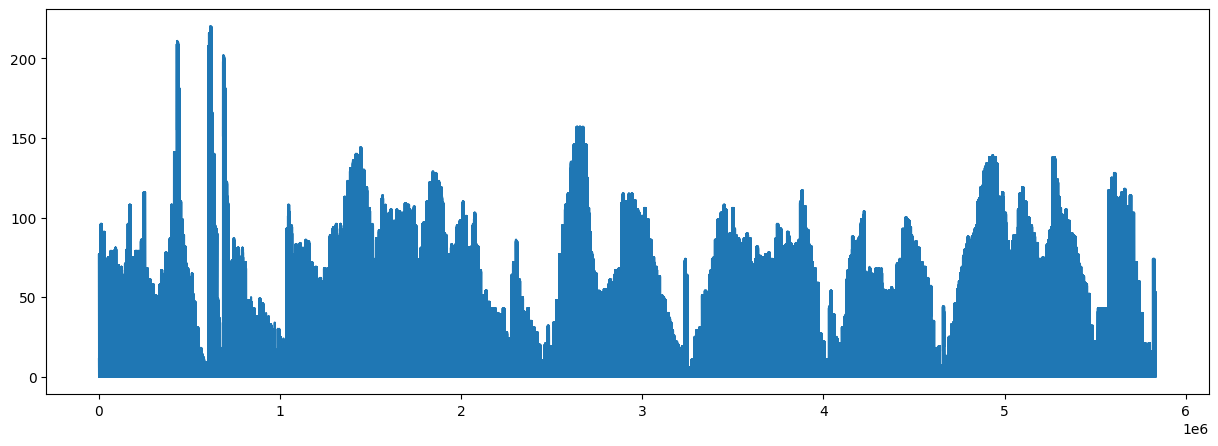

In [36]:
result_df_pp['Congestion'].plot(figsize=(15, 5))